In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load test set results
df = pd.read_csv(os.path.join('..', 'test_results.csv'))
df.head()

,model,prompt_type_index,dev_split,prompt_type,prompt_index,test_split,run,TP,FP,FN,Prec,Rec,F0.5,GLEU,prompt_template
0,gpt-4-0613,0-shot_7,fce-dev,0-shot,7,fce-test,1,2233,2110,2356,0.5142,0.4866,0.5084,NaN,system: You are a grammatical error correction...
1,gpt-3.5-turbo-0613,0-shot_5,fce-dev,0-shot,5,fce-test,1,2345,3136,2244,0.4278,0.5110,0.4422,NaN,system: You are an English language teacher. A...
2,stabilityai/StableBeluga2,0-shot_7,fce-dev,0-shot,7,fce-test,1,2077,2491,2512,0.4547,0.4526,0.4543,NaN,### System: You are a grammatical error correc...
3,facebook/opt-iml-max-30b,0-shot_7,fce-dev,0-shot,7,fce-test,1,835,627,3754,0.5711,0.1820,0.4000,NaN,You are a grammatical error correction tool. Y...
4,command,0-shot_6,fce-dev,0-shot,6,fce-test,1,1731,2426,2858,0.4164,0.3772,0.4079,NaN,You are a grammatical error correction tool. Y...


In [3]:
# split prompt_type on hyphen and take the first
df['prompt_type'] = df['prompt_type'].apply(lambda x: x.split('-')[0])

In [4]:
df.test_split.value_counts()

test_split
fce-test        10
jfleg-test      10
conll14-test    10
Name: count, dtype: int64

In [5]:
def filter_df(df, test_split):
    dfsplit = df[df['test_split'] == test_split]
    # select columns: model, F0.5
    metric = 'F0.5'
    if 'jfleg' in test_split:
        metric = 'GLEU'
    dfsplit = dfsplit[['model', metric, 'prompt_type']]
    # add column "type", initialise to open-source
    dfsplit['type'] = 'open-source'
    # if 'gpt' or 'command' in 'model", set "type" to 'commercial'
    dfsplit.loc[dfsplit['model'].str.contains('gpt|command'), 'type'] = 'commercial'

    return dfsplit

In [6]:
# format model column
def format(row):
    if '/' in row['model']:
        m = row['model'].split('/')[1]
    else:
        m = row['model']

    return m

In [8]:
def get_related_work(split):
    related_work = 'related-work'
    metric = 'F0.5'
    if split == 'jfleg-test':
        metric = 'GLEU'
        # load related work and supervised model
        # Fang-gpt-3.5-turbo,0.614,0,{related_work}
        # Fang-gpt-3.5-turbo,0.587,1,{related_work}
        # Fang-gpt-3.5-turbo,0.625,5,{related_work}
        # Loem-gpt-3.5-turbo,0.670,16,{related_work}
        # Coyne-gpt-3.5-dvnci-003,0.634,2,{related_work}
        r = f"""
        Fang-gpt-3.5-turbo,0.635,3,{related_work}
        Loem-gpt-3.5-turbo,0.693,64,{related_work}
        Coyne-gpt-3.5-dvnci-003,0.650,2,{related_work}
        S&K-2021,0.647,--,supervised"""
        
        # drop 'prompt_type'
        # dfr = dfr.drop(columns=['prompt_type'])
    if split == 'conll14-test':
        
        r = f"""
        Fang-gpt-3.5-turbo,0.532,3,{related_work}
        Loem-gpt-3.5-turbo,0.570,16,{related_work}
        S&K-2021,0.666,--,supervised
        Y&B-2021,0.629,--,supervised
        Zhou-2023,0.696,--,supervised"""
    if split == 'fce-test':
        r = f"""
        Y&B-2021,0.626,--,supervised"""

    r = [x.split(',') for x in r.split('\n') if x]
    dfr = pd.DataFrame(r, columns=['model', metric, 'prompt_type', 'type'])
    # model column to remove whitespace from strings
    dfr['model'] = dfr['model'].str.strip()

    return dfr

In [9]:
def get_dataframe_for_split(df, split):
    metric = 'F0.5'
    if 'jfleg' in split:
        metric = 'GLEU'
    # filter dataframe
    dfsplit = filter_df(df, split)
    # format model column
    dfsplit['model'] = dfsplit.apply(format, axis=1)
    # get related work
    dfr = get_related_work(split)
    # merge dataframes
    dfjoint = pd.concat([dfsplit, dfr])
    dfjoint['model'] = dfjoint['model'].str.strip()
    # convert metric to float
    dfjoint[metric] = dfjoint[metric].astype(float)
    
    model_size = {
        'GPT-4-0613': 9.0,
        'GPT-3.5T-0613': 5,
        'Cohere': 4,
        'OPT': 30,
        'Flan-T5': 11,
        'Falcon': 40,
        'Stablebeluga2': 70,
        'Llama2': 70,
        'InstructPalmyra': 20,
        'Bloomz': 7,
        'Loem-gpt-3.5-turbo': 0.7,
        'Coyne-gpt-3.5-dvnci-003': 0.7,
        'Fang-gpt-3.5-turbo': 0.7,
        'S&K-2021': 0.7,
        'Y&B-2021': 0.7,
        'Zhou-2023': 0.7
    }

    # rename model with dictionary mapping
    model_name_map = {}
    model_name_map['gpt-4-0613'] = 'GPT-4-0613'
    model_name_map['gpt-3.5-turbo-0613'] = 'GPT-3.5T-0613'
    model_name_map['command'] = 'Cohere'
    model_name_map['opt-iml-max-30b'] = 'OPT'
    model_name_map['flan-t5-xxl'] = 'Flan-T5'
    model_name_map['falcon-40b-instruct'] = 'Falcon'
    model_name_map['StableBeluga2'] = 'Stablebeluga2'
    model_name_map['Llama-2-70b-chat-hf'] = 'Llama2'
    model_name_map['InstructPalmyra-20b'] = 'InstructPalmyra'
    model_name_map['bloomz-7b1'] = 'Bloomz'
    model_name_map['Loem-gpt-3.5-turbo'] = 'Loem-gpt-3.5-turbo'
    model_name_map['Coyne-gpt-3.5-dvnci-003'] = 'Coyne-gpt-3.5-dvnci-003'
    model_name_map['Fang-gpt-3.5-turbo'] = 'Fang-gpt-3.5-turbo'
    model_name_map['S&K-2021'] = 'S&K-2021'
    model_name_map['Y&B-2021'] = 'Y&B-2021'
    model_name_map['Zhou-2023'] = 'Zhou-2023'

    dfjoint['model'] = dfjoint['model'].map(model_name_map)

    # add model size
    dfjoint['model_size'] = dfjoint['model'].map(model_size)
    # sort by type then by size
    dfjoint = dfjoint.sort_values(by=['type', 'model_size'], ascending=[True, False])

    return dfjoint

In [11]:

dftest = get_dataframe_for_split(df, 'jfleg-test')
dftest

,model,GLEU,prompt_type,type,model_size
10,GPT-4-0613,0.630162,0,commercial,9.0
15,GPT-3.5T-0613,0.624669,4,commercial,5.0
18,Cohere,0.592397,2,commercial,4.0
11,Stablebeluga2,0.613442,0,open-source,70.0
12,Llama2,0.560125,0,open-source,70.0
17,Falcon,0.602033,4,open-source,40.0
14,OPT,0.521456,2,open-source,30.0
13,InstructPalmyra,0.571803,0,open-source,20.0
16,Flan-T5,0.507805,1,open-source,11.0
19,Bloomz,0.497882,2,open-source,7.0


In [14]:
def plot(df, title, add_size=False, add_examples=False):
    
    # plot model vs F0.5
    sns.set_theme(style="white")
    plt.figure(figsize=(10, 6))

    # ax = sns.barplot(x="model", y="F0.5", data=df, hue='type')
    colors = sns.color_palette()
    
    # barplot set color for type
    metric = 'F0.5'
    if 'jfleg' in title.lower():
        metric = 'GLEU'
    ax = sns.barplot(x="model", y=metric, data=df, hue='type', palette={
        'open-source': colors[1], 'commercial': colors[0], 'supervised': colors[3], 'related-work': colors[2]})

    ax.set_title(title)
    ax.set_xlabel('Model')
    # rotate x-labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    # set y-axis direction
    # ax.invert_yaxis()
    ax.set_ylabel(metric)
    # set y-axis limits
    ax.set_ylim(0.2, 0.8)

    # move legend outside
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1.022), title='Type')

    # add model_size to bars only for 'open-source' models
    if add_size:
        for i in range(len(df)):
            if df.iloc[i]['type'] == 'open-source':
                ax.text(i, df.iloc[i][metric], f"{int(df.iloc[i]['model_size'])}B", ha='center', va='bottom')
    
    # add prompt_type to bars for all models except 'supervised'
    # position is fixed
    if add_examples:
        for i in range(len(df)):
            if df.iloc[i]['type'] != 'supervised':
                ax.text(i, 0.3, df.iloc[i]['prompt_type'], ha='center', va='bottom', fontdict={'size': 14}, backgroundcolor='white')

In [48]:
# print seaborn color palette with RBG tuples next to the color
a = sns.color_palette()
for i in a:
    print(i)

(0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
(0.8666666666666667, 0.5176470588235295, 0.3215686274509804)
(0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
(0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
(0.5058823529411764, 0.4470588235294118, 0.7019607843137254)
(0.5764705882352941, 0.47058823529411764, 0.3764705882352941)
(0.8549019607843137, 0.5450980392156862, 0.7647058823529411)
(0.5490196078431373, 0.5490196078431373, 0.5490196078431373)
(0.8, 0.7254901960784313, 0.4549019607843137)
(0.39215686274509803, 0.7098039215686275, 0.803921568627451)


In [51]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

/tmp/ipykernel_3186210/1078351674.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


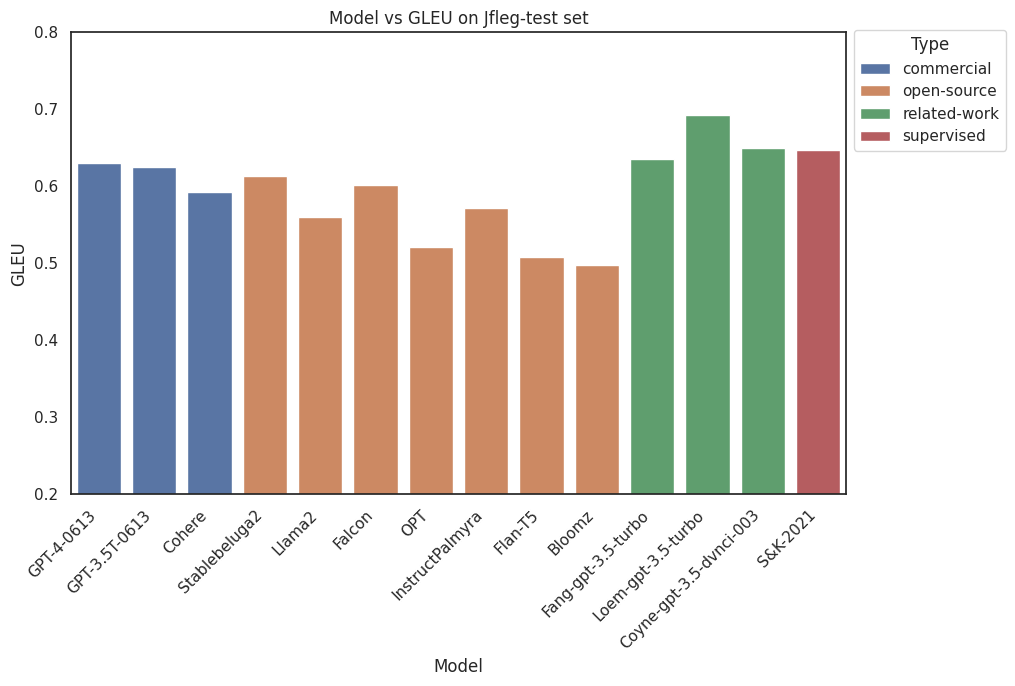

In [17]:
split = 'jfleg-test'
metric = 'F0.5'
if 'jfleg' in split:
    metric = 'GLEU'
dfplot = get_dataframe_for_split(df, split)
plot(dfplot, f'Model vs {metric} on {split.capitalize()} set', add_size=False, add_examples=False)

In [44]:
dfplot

,model,F0.5,type,model_size
20,GPT-4-0613,0.6055,commercial,9.0
25,GPT-3.5T-0613,0.5720,commercial,5.0
22,Cohere,0.5384,commercial,4.0
21,Stablebeluga2,0.5716,open-source,70.0
23,Llama2,0.5175,open-source,70.0
24,Falcon,0.5601,open-source,40.0
27,OPT,0.3956,open-source,30.0
28,InstructPalmyra,0.4993,open-source,20.0
26,Flan-T5,0.3967,open-source,11.0
29,Bloomz,0.4047,open-source,7.0
